# Import Lib

In [76]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from tsfresh import extract_features
from tsfresh.feature_extraction import settings

from imblearn.under_sampling import RandomUnderSampler
from statsmodels.tsa.stattools import acf
from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from catboost import CatBoostClassifier, Pool

# Load data

In [77]:
data = pd.read_parquet('./data/train.parquet')
data.head()

id                                              dates  \
0  19114  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   
1  22769  [2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...   
2  76935  [2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...   
3  66297  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   
4   2191  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   

                                              values  label  
0  [-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....    0.0  
1  [-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...    1.0  
2  [0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...    0.0  
3  [-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...    0.0  
4  [1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...    0.0

In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      80000 non-null  int64  
 1   dates   80000 non-null  object 
 2   values  80000 non-null  object 
 3   label   80000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.4+ MB


# Data preprocessing

Сначала проверим есть ли пустые значения и одинаковой ли длины наши столбцы dates и values

In [79]:
data['values_has_empty'] = data['values'].apply(lambda x: any(pd.isnull(v) for v in x))
data['dates_has_empty'] = data['dates'].apply(lambda x: any(pd.isnull(v) for v in x))
data['same_length'] = data.apply(lambda row: len(row['dates']) == len(row['values']), axis=1)

In [80]:
data.head(3)

id                                              dates  \
0  19114  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   
1  22769  [2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...   
2  76935  [2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...   

                                              values  label  values_has_empty  \
0  [-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....    0.0             False   
1  [-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...    1.0             False   
2  [0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...    0.0             False   

   dates_has_empty  same_length  
0            False         True  
1            False         True  
2            False         True

In [81]:
print(f'Empty values in values: {data['values_has_empty'].value_counts()}')
print(f'Empty values in dates: {data['dates_has_empty'].value_counts()}')

Empty values in values: values_has_empty
False    79912
True        88
Name: count, dtype: int64
Empty values in dates: dates_has_empty
False    80000
Name: count, dtype: int64


In [82]:
data = data[(data['values_has_empty'] == False)
            & (data['dates_has_empty'] == False)
            & (data['same_length'] == True)].drop(['values_has_empty', 'dates_has_empty', 'same_length'], axis=1)

In [83]:
data

id                                              dates  \
0      19114  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   
1      22769  [2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...   
2      76935  [2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...   
3      66297  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   
4       2191  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   
...      ...                                                ...   
79995  71474  [2018-10-01, 2018-11-01, 2018-12-01, 2019-01-0...   
79996  36908  [2016-07-01, 2016-08-01, 2016-09-01, 2016-10-0...   
79997  63517  [2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...   
79998  94731  [2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...   
79999  98870  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   

                                                  values  label  
0      [-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....    0.0  
1      [-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...    1.0  
2      [0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...    0.0  
3      [-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...    0.0  
4      [1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...    0.0  
...                                                  ...    ...  
79995  [-0.15, -1.13, -0.87, 0.49, 0.87, 1.67, 1.91, ...    0.0  
79996  [-0.35, -1.31, 0.11, 1.46, 1.28, 1.12, 1.78, 1...    1.0  
79997  [-0.78, -2.27, -1.85, -0.67, -1.2, -2.02, 0.12...    0.0  
79998  [-2.29, -2.85, 0.92, -0.83, -1.75, -1.81, -2.2...    0.0  
79999  [0.12, -0.8, 1.62, 0.11, -0.38, -0.86, -0.85, ...    1.0  

[79912 rows x 4 columns]

In [10]:
all_dates = [date for sublist in data['dates'] for date in sublist]
all_dates = pd.to_datetime(all_dates)

print(f"Минимальная дата: {all_dates.min().date()}")
print(f"Максимальная дата: {all_dates.max().date()}")

Минимальная дата: 2016-01-01
Максимальная дата: 2024-01-01


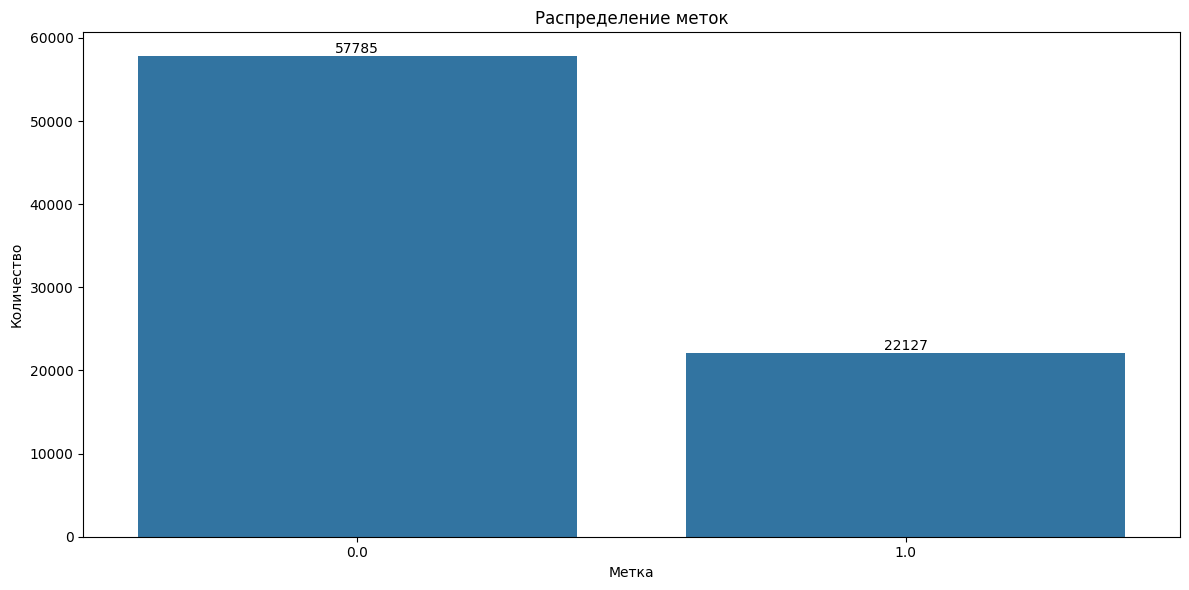

In [11]:
count_data = data['label'].value_counts()

plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='label')
for index, value in enumerate(count_data):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.title('Распределение меток')
plt.xlabel('Метка')
plt.ylabel('Количество')
plt.tight_layout()
plt.show()

# EDA

## Statistical features

In [84]:
def statistical_extract_features(values):
    return [
        np.mean(values),
        np.std(values),
        np.min(values),
        np.max(values),
        np.median(values),
        np.percentile(values, 25),
        np.percentile(values, 75),
        len(values),
        (np.max(values) - np.min(values))
    ]

In [85]:
data['features'] = data['values'].apply(statistical_extract_features)
data = pd.merge(data,
                pd.DataFrame(data['features'].tolist(),
                             columns=['mean', 'std', 'min','max','median', 'q25', 'q75', 'frequency', 'amplitude']).assign(id=data['id'].values),
                on='id', how='inner').drop('features', axis=1)

In [14]:
data.head(3)

id                                              dates  \
0  19114  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   
1  22769  [2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...   
2  76935  [2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...   

                                              values  label      mean  \
0  [-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....    0.0  0.023710   
1  [-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...    1.0 -0.310777   
2  [0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...    0.0 -0.046042   

        std       min   max    median     q25    q75  frequency  amplitude  
0  1.337272 -4.840000  3.49 -0.110000 -0.6825  0.770         62   8.330000  
1  1.556337 -3.534409  2.92 -0.274409 -1.0400  0.710         45   6.454409  
2  1.065023 -1.950000  2.61 -0.145000 -0.8775  0.615         48   4.560000

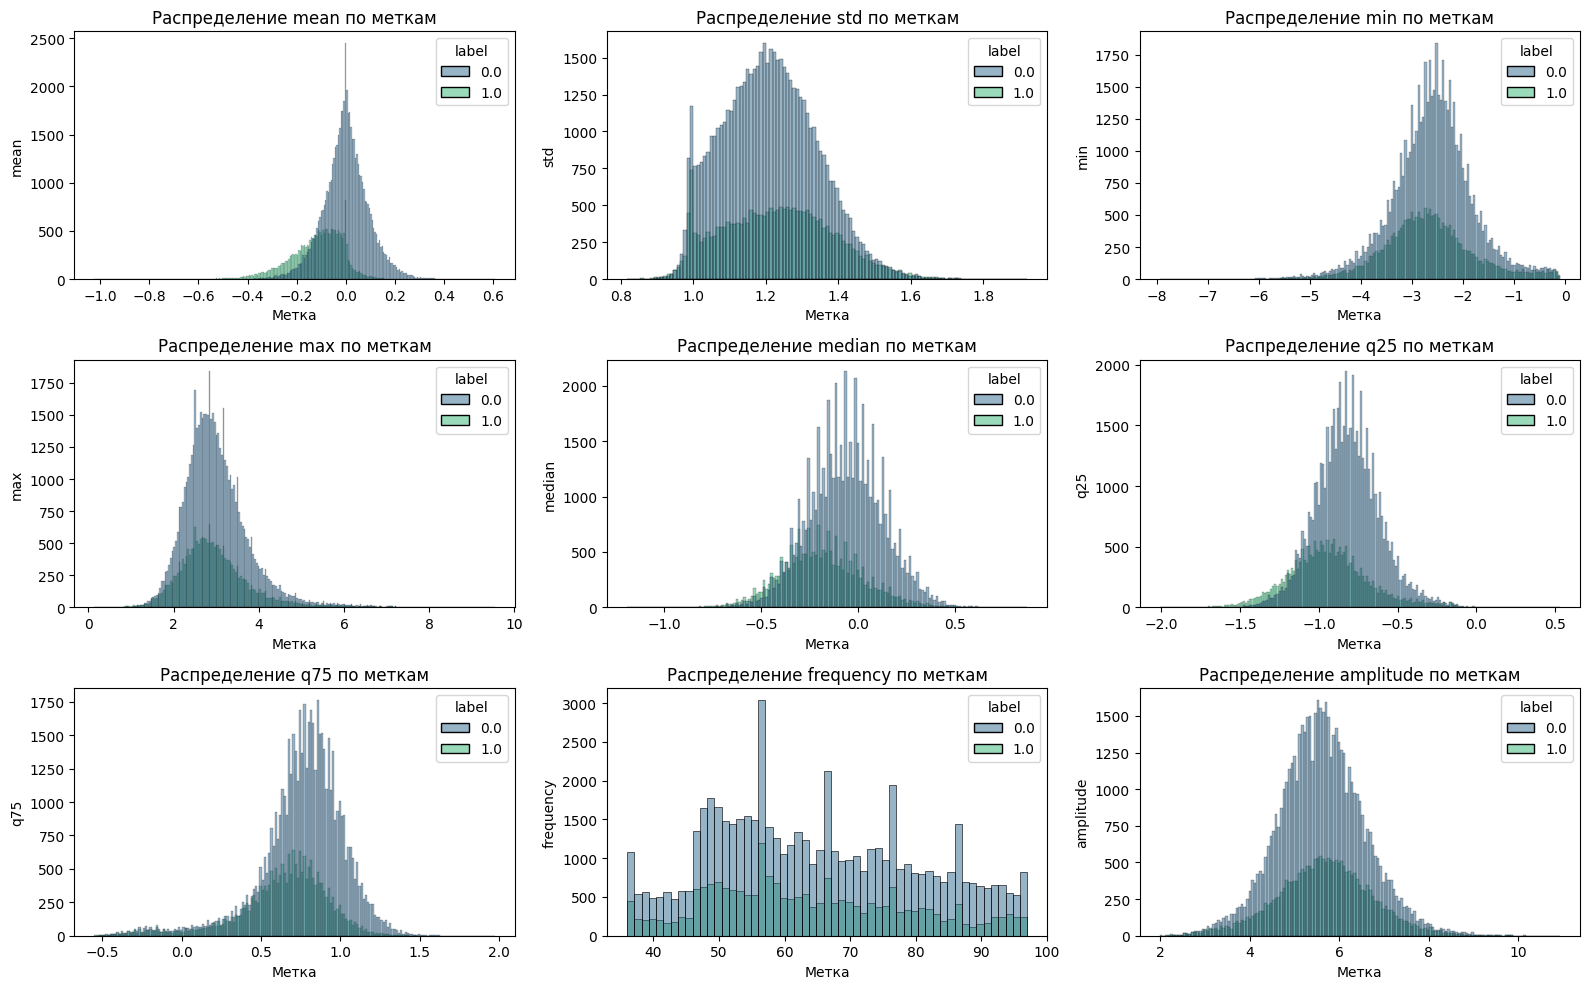

In [15]:
features_to_plot = ['mean', 'std', 'min', 'max', 'median', 'q25', 'q75', 'frequency', 'amplitude']

plt.figure(figsize=(16, 10))
for i, feature in enumerate(features_to_plot):
    plt.subplot(3, 3, i + 1)
    sns.histplot(data=data, x=feature, hue='label', palette='viridis')
    plt.title(f'Распределение {feature} по меткам')
    plt.xlabel('Метка')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

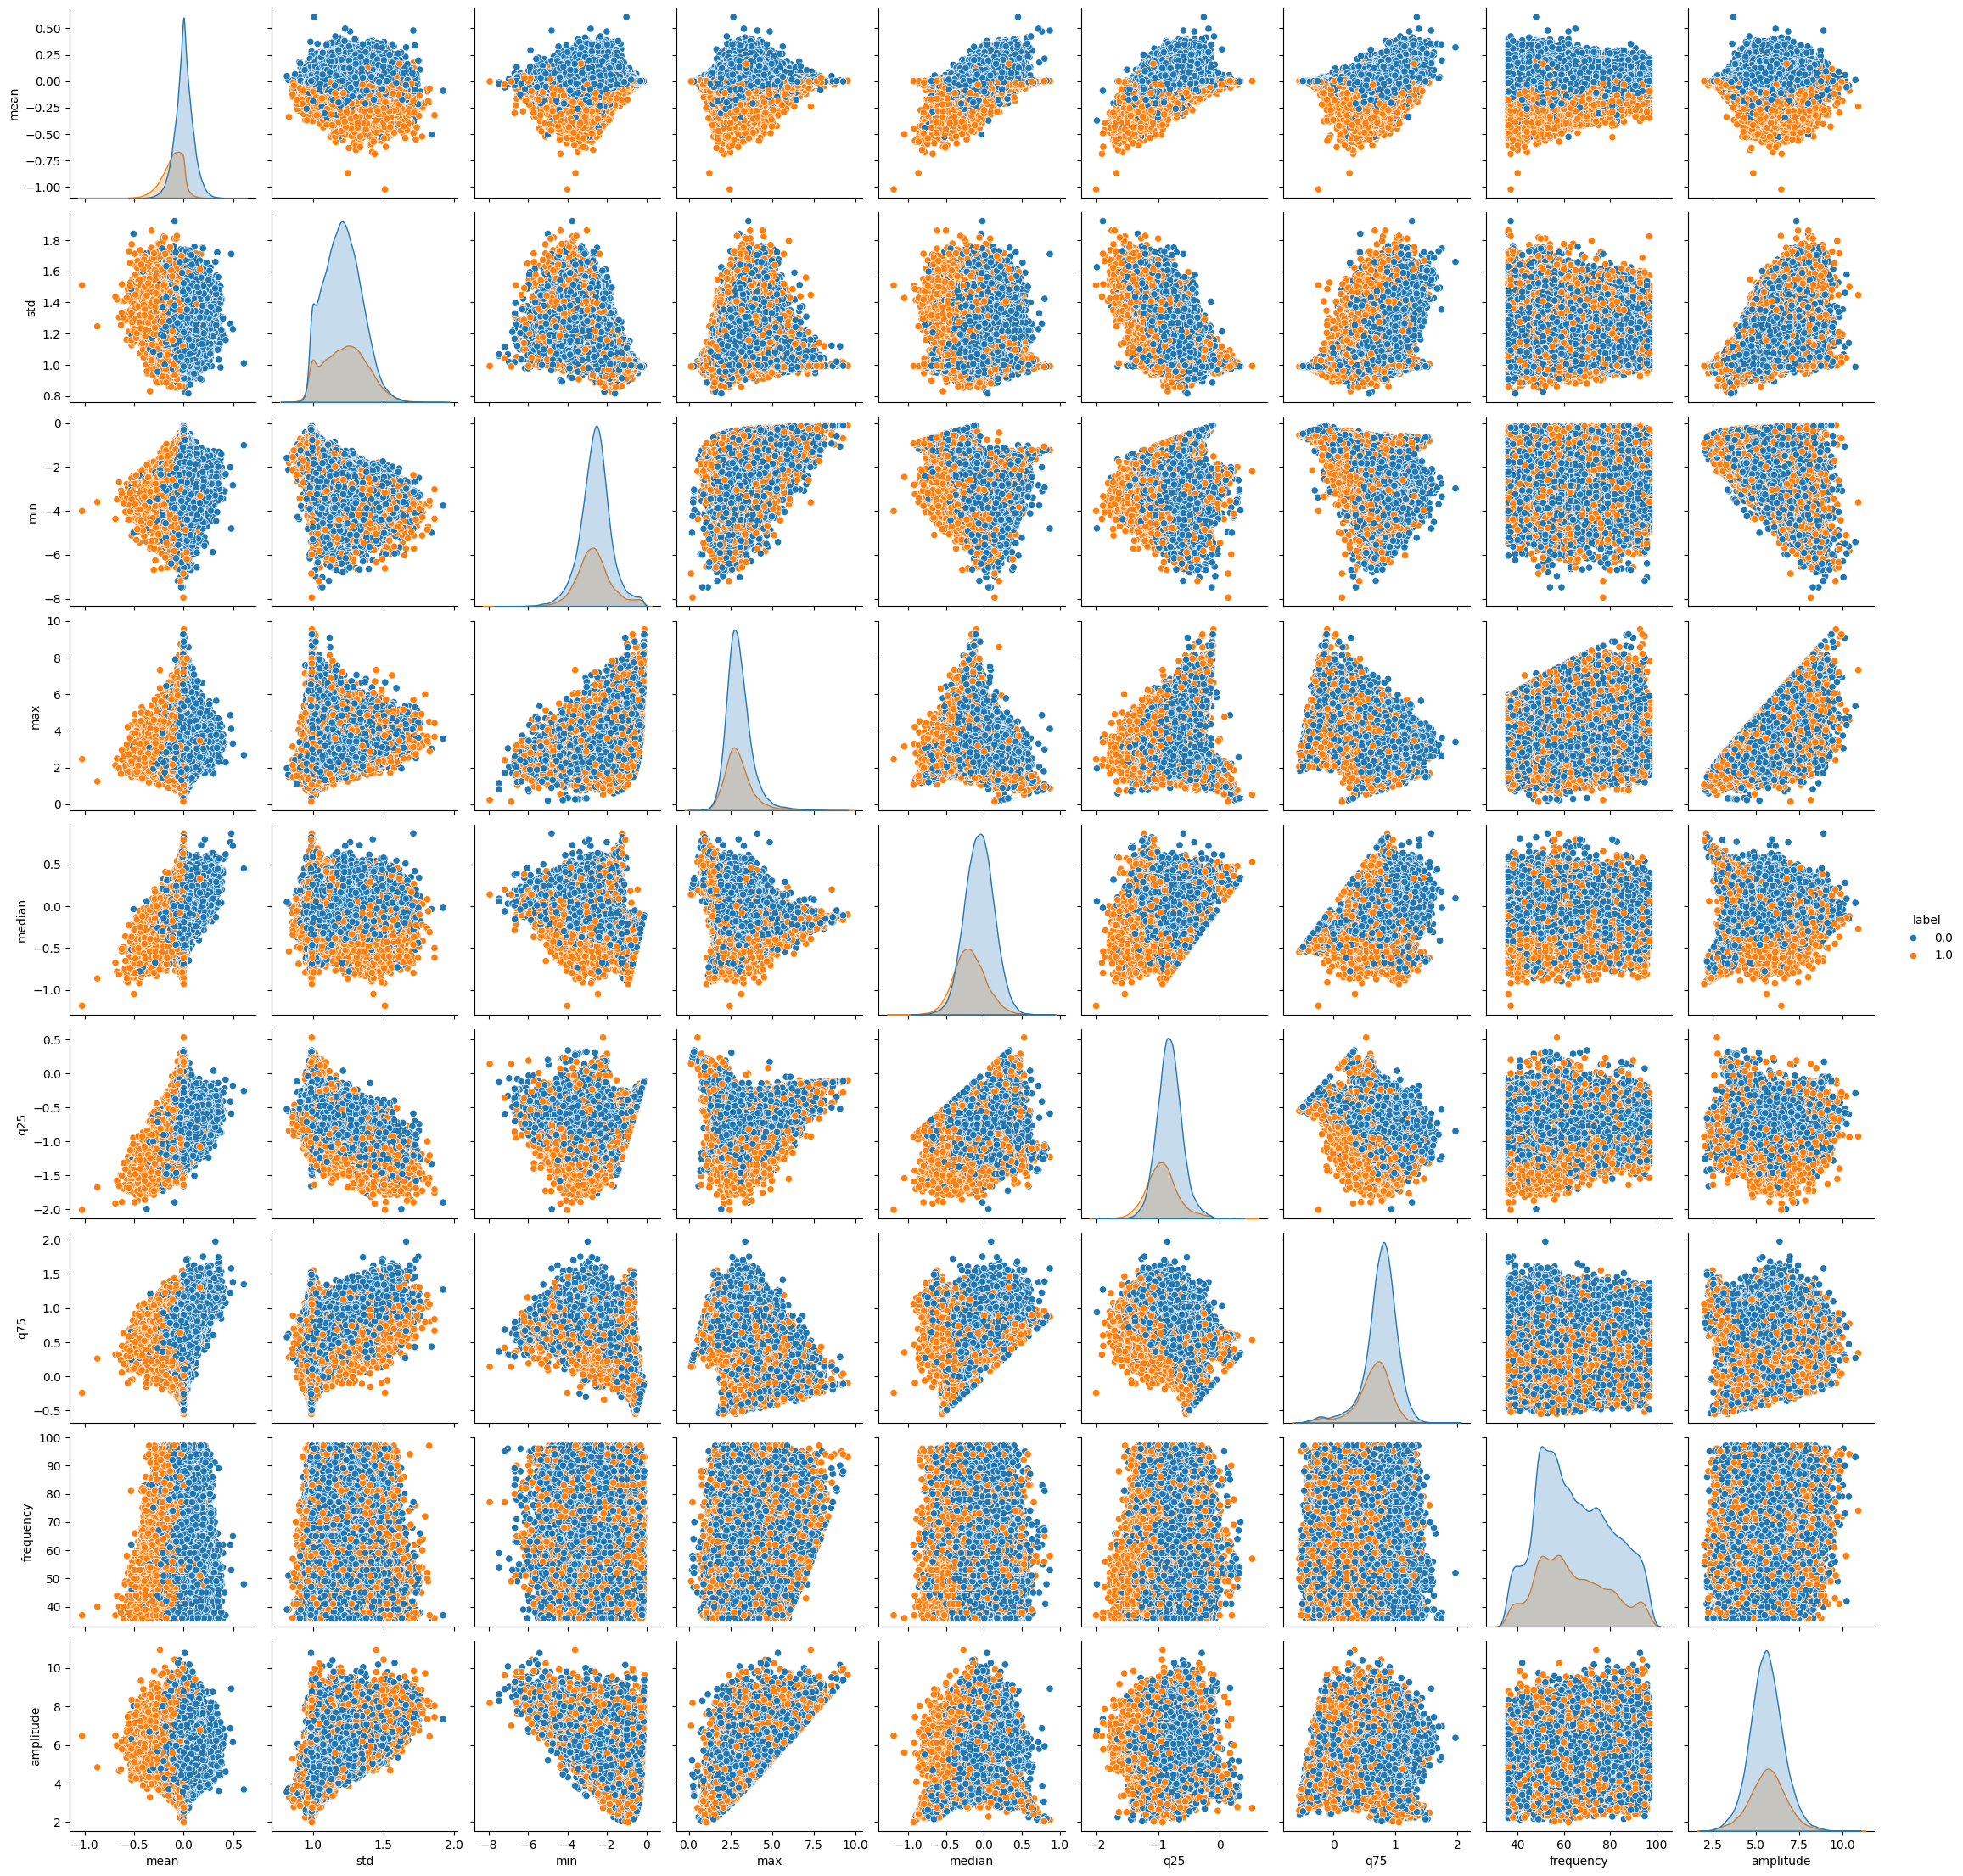

In [16]:
features_to_plot = ['label', 'mean', 'std', 'min', 'max', 'median', 'q25', 'q75', 'frequency', 'amplitude']

sns.pairplot(data[features_to_plot], hue='label')
plt.show()

## Time Plot

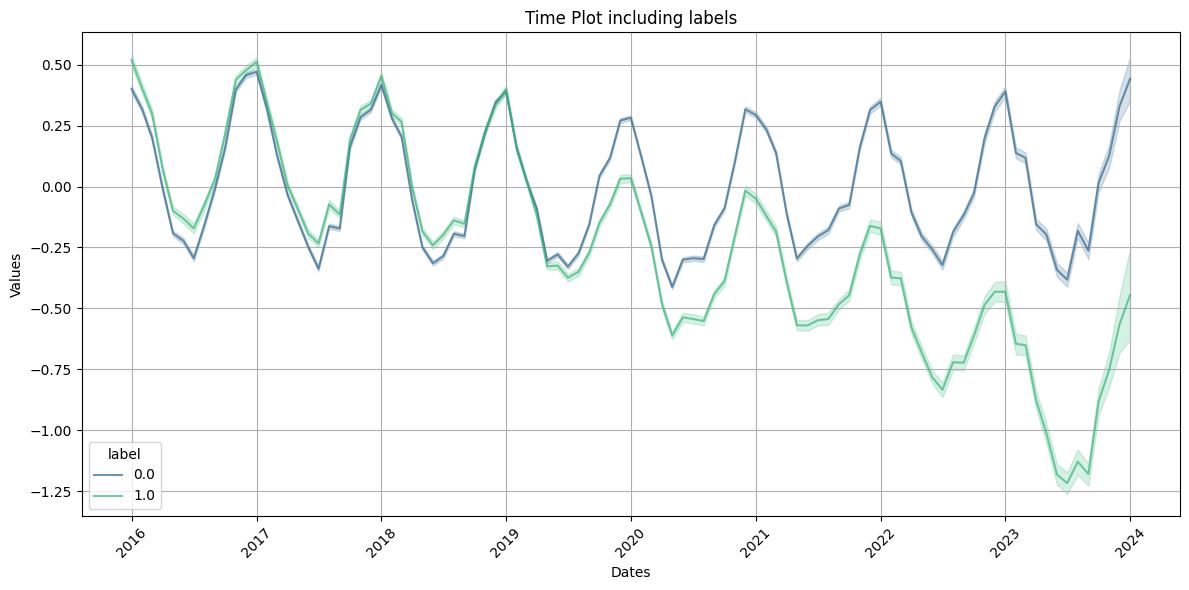

In [17]:
data_plot = data.explode(['dates', 'values']).reset_index(drop=True)
data_plot['dates'] = pd.to_datetime(data_plot['dates'])
data_plot['values'] = data_plot['values'].astype(float)

plt.figure(figsize=(12, 6))
sns.lineplot(data=data_plot, x='dates', y='values', hue='label', palette='viridis', alpha=0.7)
plt.title('Time Plot including labels')
plt.xlabel('Dates')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

Можем увидеть, что после 2020 года метки начали расходится. В 2020 году был COVID-19, можем сделать вывод, что он повлиял на наши данные 

## Seasonal Plots

In [18]:
data_plot['year'] = data_plot['dates'].dt.year
data_plot['month'] = data_plot['dates'].dt.month
data_plot['week'] = data_plot['dates'].dt.isocalendar().week
data_plot['day'] = data_plot['dates'].dt.day_of_week
data_plot['day_str'] = data_plot['dates'].dt.day_name()
data_plot['year_month'] = data_plot['dates'].dt.to_period('M')

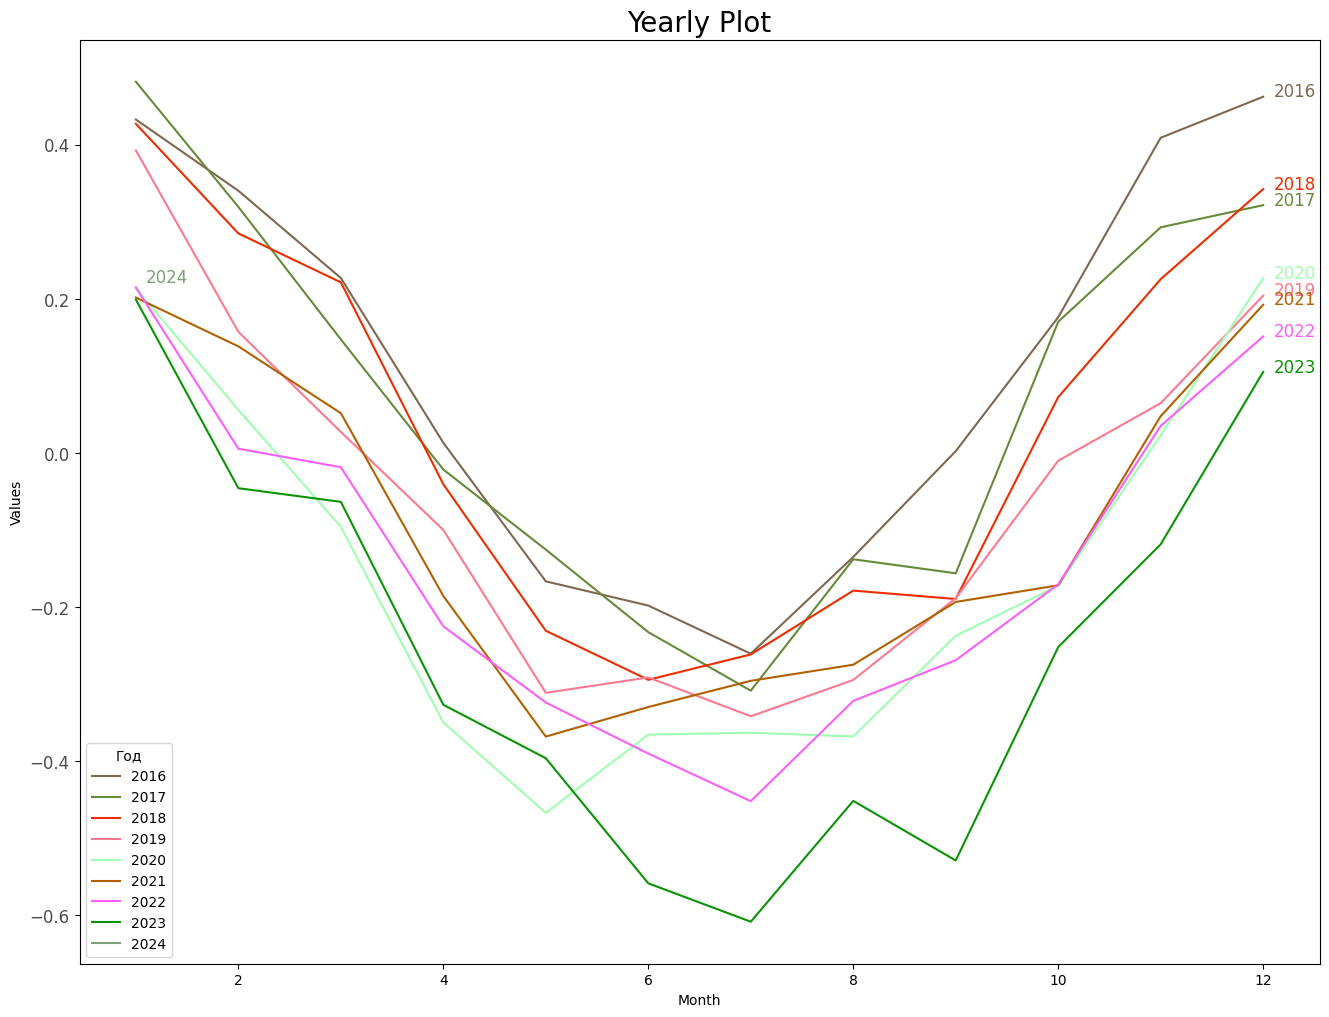

In [19]:
df_plot = data_plot[['month', 'year', 'values']].dropna().groupby(['month', 'year']).mean()[['values']].reset_index()
years = df_plot['year'].unique()
colors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

plt.figure(figsize=(16,12))
for i, y in enumerate(years):
    plt.plot('month', 'values', data=df_plot[df_plot['year'] == y], color=colors[i], label=y)
    plt.text(df_plot.loc[df_plot.year==y, :].shape[0]+0.1, df_plot.loc[df_plot.year==y, 'values'].values[-1], y, fontsize=12, color=colors[i])

plt.gca().set(ylabel='Values', xlabel='Month')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Yearly Plot", fontsize=20)
plt.legend(title='Год')
plt.show()

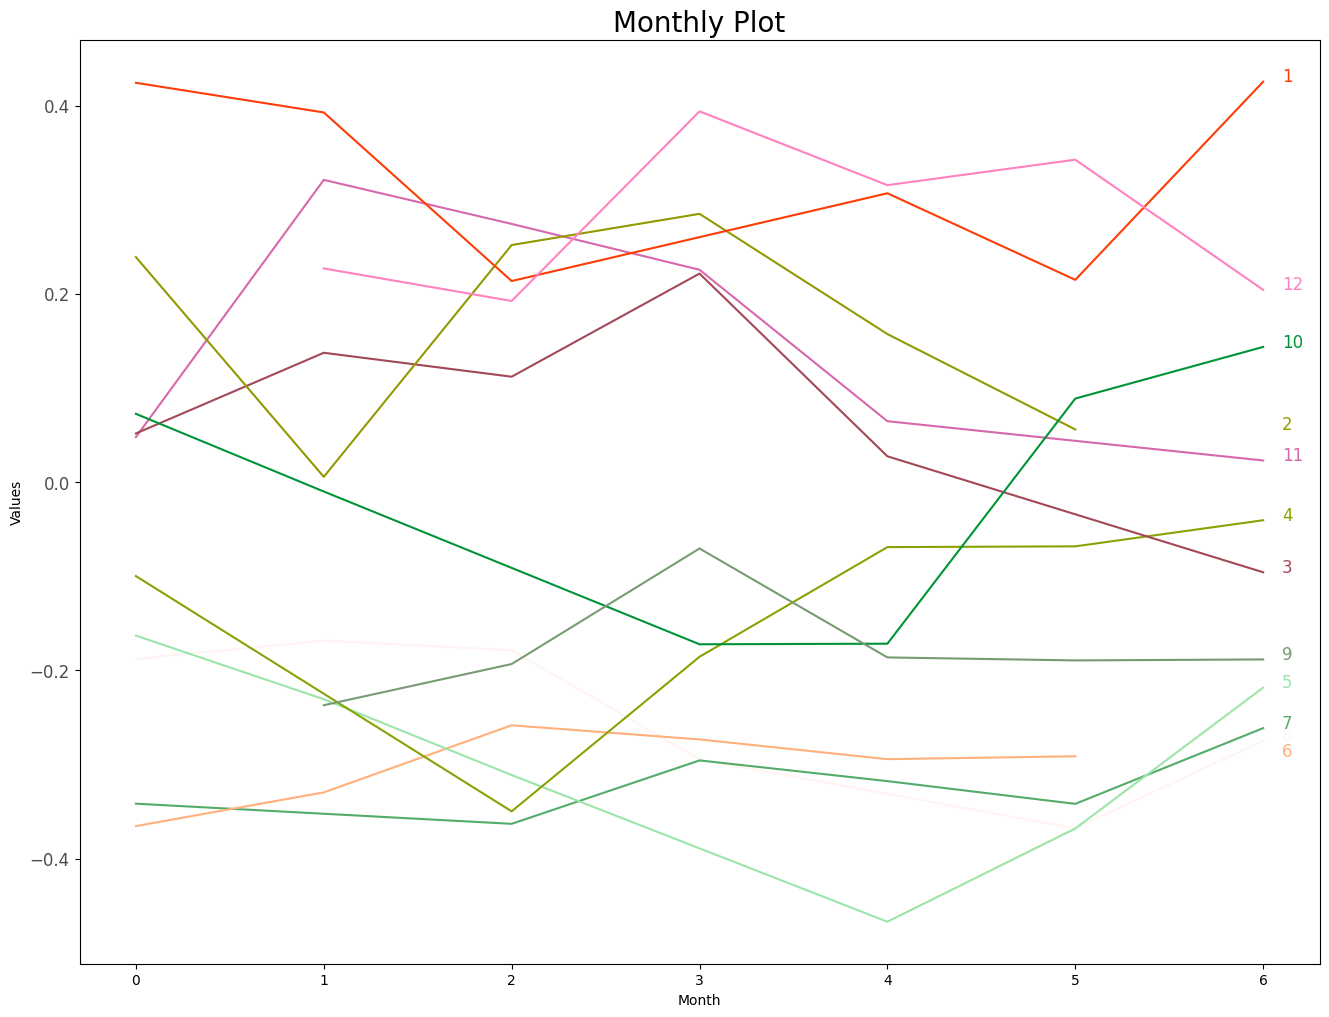

In [20]:
df_plot = data_plot[['month', 'day_str', 'values', 'day']].groupby(['day_str', 'month', 'day']).mean()[['values']].reset_index()
df_plot = df_plot.sort_values(by='day', ascending=True)

months = df_plot['month'].unique()
colors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(months), replace=False)

plt.figure(figsize=(16,12))
for i, y in enumerate(months):
    plt.plot('day', 'values', data=df_plot[df_plot['month'] == y], color=colors[i], label=y)
    plt.text(df_plot.loc[df_plot.month==y, :].shape[0]+.1, df_plot.loc[df_plot.month==y, 'values'][-1:].values[0], y, fontsize=12, color=colors[i])

plt.gca().set(ylabel='Values', xlabel='Month')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Monthly Plot", fontsize=20)
plt.show()

## Box Plots

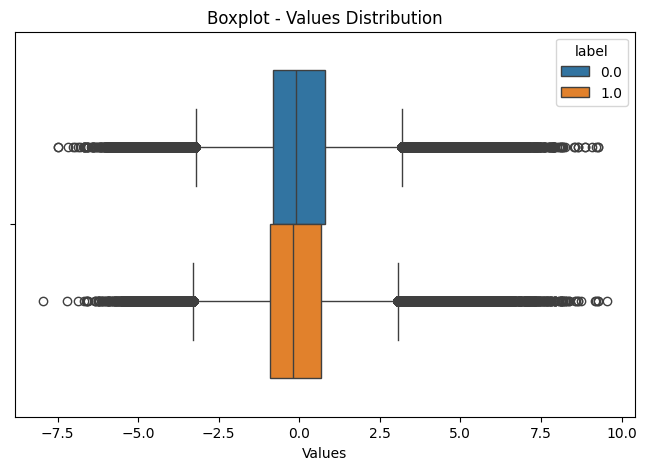

In [21]:
plt.figure(figsize=(8,5))
sns.boxplot(data=data_plot, x='values', hue='label')
plt.xlabel('Values')
plt.title(f'Boxplot - Values Distribution');

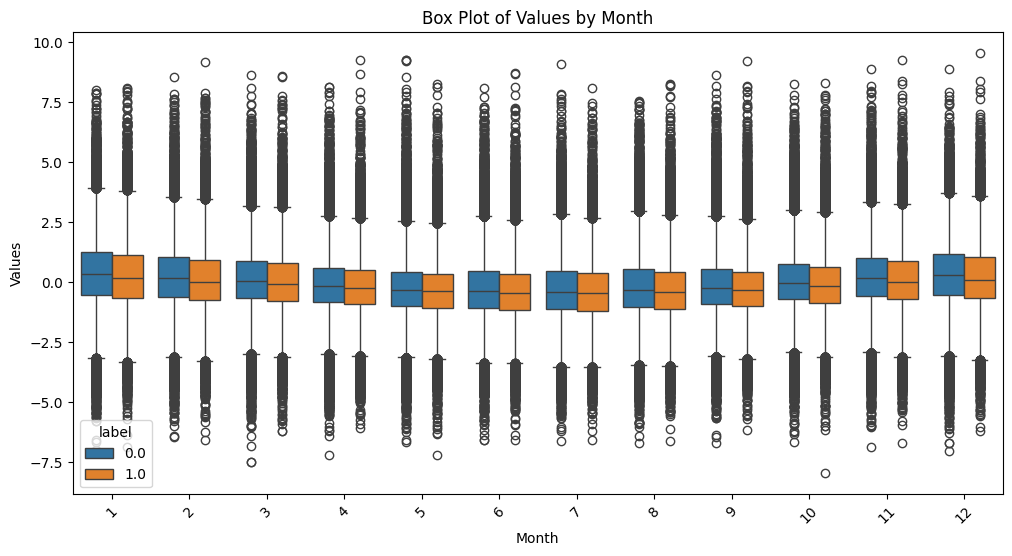

In [22]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_plot, x='month', y='values', hue='label')
plt.title('Box Plot of Values by Month')
plt.xlabel('Month')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()

## Feature engineering

Сгенерируем тренд (наклон) указывающий, в какую сторону и с какой скоростью изменяются значения

In [86]:
def dates_to_numbers(dates):
    dates = pd.to_datetime(dates)

    return dates.map(pd.Timestamp.toordinal).values

In [87]:
def compute_slope(dates, values):
    x = dates_to_numbers(dates).reshape(-1, 1)
    y = np.array(values)

    if len(x) < 2:
        return np.nan
    model = LinearRegression()
    model.fit(x, y)

    return model.coef_[0]

In [88]:
data['trend'] = data.apply(lambda row: compute_slope(row['dates'], row['values']), axis=1)

In [26]:
data.head(3)

id                                              dates  \
0  19114  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   
1  22769  [2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...   
2  76935  [2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...   

                                              values  label      mean  \
0  [-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....    0.0  0.023710   
1  [-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...    1.0 -0.310777   
2  [0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...    0.0 -0.046042   

        std       min   max    median     q25    q75  frequency  amplitude  \
0  1.337272 -4.840000  3.49 -0.110000 -0.6825  0.770         62   8.330000   
1  1.556337 -3.534409  2.92 -0.274409 -1.0400  0.710         45   6.454409   
2  1.065023 -1.950000  2.61 -0.145000 -0.8775  0.615         48   4.560000   

      trend  
0 -0.000368  
1 -0.000878  
2 -0.001065

Добавим среднее производной

In [89]:
data['dv_mean'] = data['values'].apply(lambda x: np.mean(np.diff(x)))

In [29]:
data.head(1)

id                                              dates  \
0  19114  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   

                                              values  label     mean  \
0  [-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....    0.0  0.02371   

        std   min   max  median     q25   q75  frequency  amplitude     trend  \
0  1.337272 -4.84  3.49   -0.11 -0.6825  0.77         62       8.33 -0.000368   

    dv_mean  
0  0.021148

Добавим автокорелляцию

In [90]:
data['autocorr'] = data['values'].apply(lambda x: acf(x, nlags=1)[1])

In [31]:
data.head(1)

id                                              dates  \
0  19114  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   

                                              values  label     mean  \
0  [-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....    0.0  0.02371   

        std   min   max  median     q25   q75  frequency  amplitude     trend  \
0  1.337272 -4.84  3.49   -0.11 -0.6825  0.77         62       8.33 -0.000368   

    dv_mean  autocorr  
0  0.021148 -0.111439

Попробуем преобразование Фурье

In [91]:
data['fft_freq'] = data['values'].apply(lambda x: np.fft.fftfreq(len(x)).mean())

In [33]:
data.head(1)

id                                              dates  \
0  19114  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   

                                              values  label     mean  \
0  [-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....    0.0  0.02371   

        std   min   max  median     q25   q75  frequency  amplitude     trend  \
0  1.337272 -4.84  3.49   -0.11 -0.6825  0.77         62       8.33 -0.000368   

    dv_mean  autocorr  fft_freq  
0  0.021148 -0.111439 -0.008065

Попробум tsfresh

In [34]:
tsfresh_data = data_plot.copy()[['values', 'id']]

In [35]:
tsfresh_data.head(3)

values     id
0   -1.86  19114
1    0.79  19114
2    1.40  19114

In [36]:
settings = settings.MinimalFCParameters()

extracted_features = extract_features(tsfresh_data, column_id='id', default_fc_parameters=settings)

Feature Extraction: 100%|██████████| 10/10 [00:24<00:00,  2.45s/it]


In [37]:
extracted_features.head(1)

values__sum_values  values__median  values__mean  values__length  \
0               -1.61           -0.16      -0.02403            67.0   

   values__standard_deviation  values__variance  values__root_mean_square  \
0                    1.032392          1.065833                  1.032672   

   values__maximum  values__absolute_maximum  values__minimum  
0             5.57                      5.57            -1.63

In [38]:
extracted_features = extracted_features.reset_index(drop=True).assign(id=data['id'].values)
data = pd.merge(data, extracted_features, on='id', how='inner')

In [41]:
data.head(1)

id                                              dates  \
0  19114  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   

                                              values  label     mean  \
0  [-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....    0.0  0.02371   

        std   min   max  median     q25  ...  values__sum_values  \
0  1.337272 -4.84  3.49   -0.11 -0.6825  ...               -1.61   

   values__median  values__mean  values__length  values__standard_deviation  \
0           -0.16      -0.02403            67.0                    1.032392   

   values__variance  values__root_mean_square  values__maximum  \
0          1.065833                  1.032672             5.57   

   values__absolute_maximum  values__minimum  
0                      5.57            -1.63  

[1 rows x 27 columns]

Добавим год

In [51]:
data['year'] = data_plot['year']

In [52]:
data.head(1)

id                                              dates  \
0  19114  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   

                                              values  label     mean  \
0  [-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....    0.0  0.02371   

        std   min   max  median     q25  ...  values__median  values__mean  \
0  1.337272 -4.84  3.49   -0.11 -0.6825  ...           -0.16      -0.02403   

   values__length  values__standard_deviation  values__variance  \
0            67.0                    1.032392          1.065833   

   values__root_mean_square  values__maximum  values__absolute_maximum  \
0                  1.032672             5.57                      5.57   

   values__minimum  year  
0            -1.63  2016  

[1 rows x 28 columns]

Проаназируем признаки

In [92]:
data_encoded = data.copy()
data_for_corr = data_encoded.drop(columns=['id', 'dates', 'values'])
correlation_matrix = data_for_corr.corr()

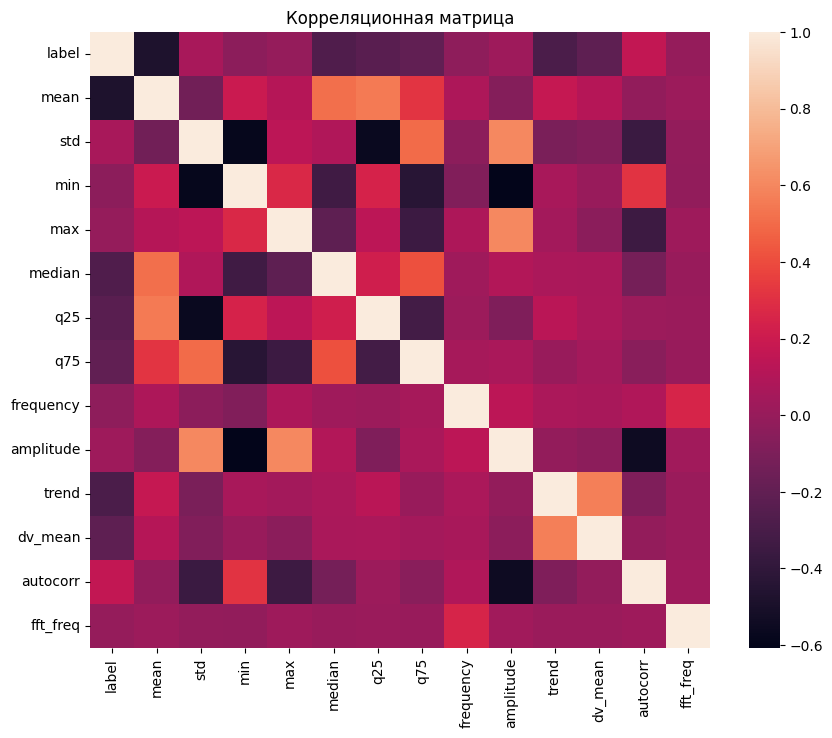

In [93]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix)
plt.title('Корреляционная матрица')
plt.show()

In [94]:
def filter_high_correlation_features(correlation_matrix, threshold=0.6):
    high_corr_var = set()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                colname = correlation_matrix.columns[i]
                high_corr_var.add(colname)
    
    return high_corr_var

In [95]:
high_correlation_features = filter_high_correlation_features(correlation_matrix)
print("Признаки с высокой корреляцией:", high_correlation_features)

Признаки с высокой корреляцией: {'amplitude'}


In [96]:
data_for_corr = data_for_corr.drop(columns=high_correlation_features)
correlation_matrix = data_for_corr.corr()

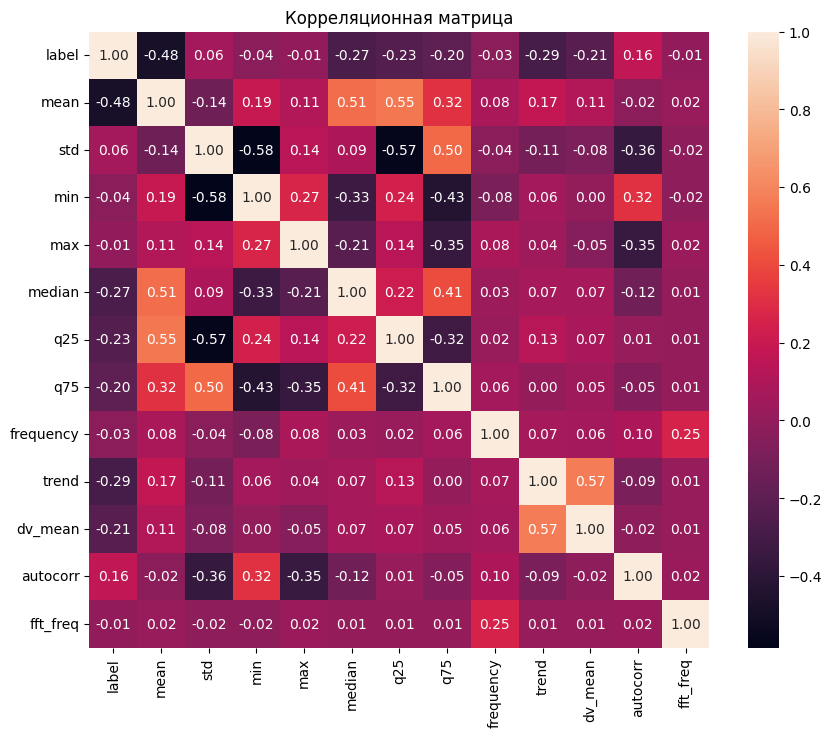

In [97]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title('Корреляционная матрица')
plt.show()

# Model

In [98]:
X, y = data_for_corr.drop(['label'], axis=1), data_for_corr['label']

In [99]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=42, test_size=0.2, stratify=y)

In [101]:
RUS = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = RUS.fit_resample(X_train, y_train)

In [102]:
train_pool = Pool(
    X_train_resampled,
    y_train_resampled
)
valid_pool = Pool(
    X_test,
    y_test
)

In [103]:
catClassifier = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.001,
    eval_metric='AUC',
    # task_type='GPU',
    early_stopping_rounds=20,
    use_best_model=True,
    verbose=50
)

In [104]:
catClassifier.fit(train_pool, eval_set=valid_pool)

0:	test: 0.8347340	best: 0.8347340 (0)	total: 21ms	remaining: 21s
50:	test: 0.8481552	best: 0.8482109 (47)	total: 738ms	remaining: 13.7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8483180637
bestIteration = 53

Shrink model to first 54 iterations.


In [105]:
predicted = catClassifier.predict(X_test)

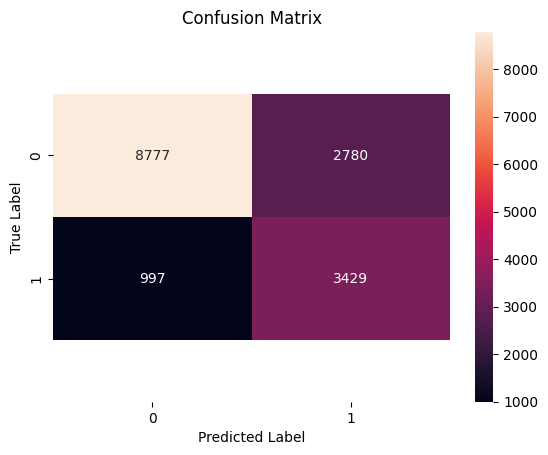

In [67]:
cm = confusion_matrix(y_test, predicted)

class_label = ["0", "1"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
ax = sns.heatmap(df_cm, annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [106]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

         0.0       0.90      0.76      0.82     11557
         1.0       0.55      0.78      0.64      4426

    accuracy                           0.76     15983
   macro avg       0.72      0.77      0.73     15983
weighted avg       0.80      0.76      0.77     15983



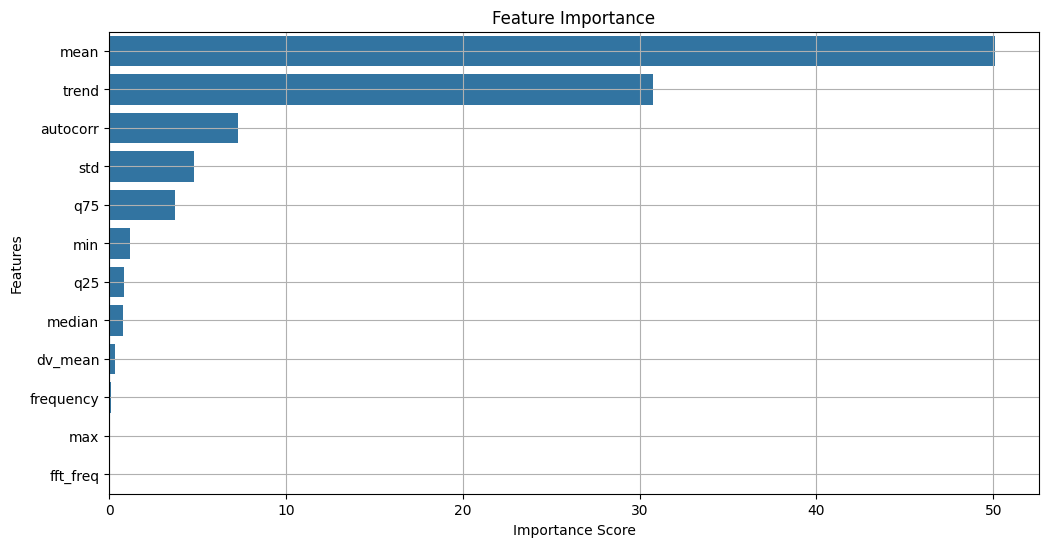

In [107]:
feature_importance = catClassifier.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importance[sorted_idx], y=np.array(X.columns)[sorted_idx], orient='h')
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.grid()
plt.show()

ROC AUC score: 0.8483180636606527


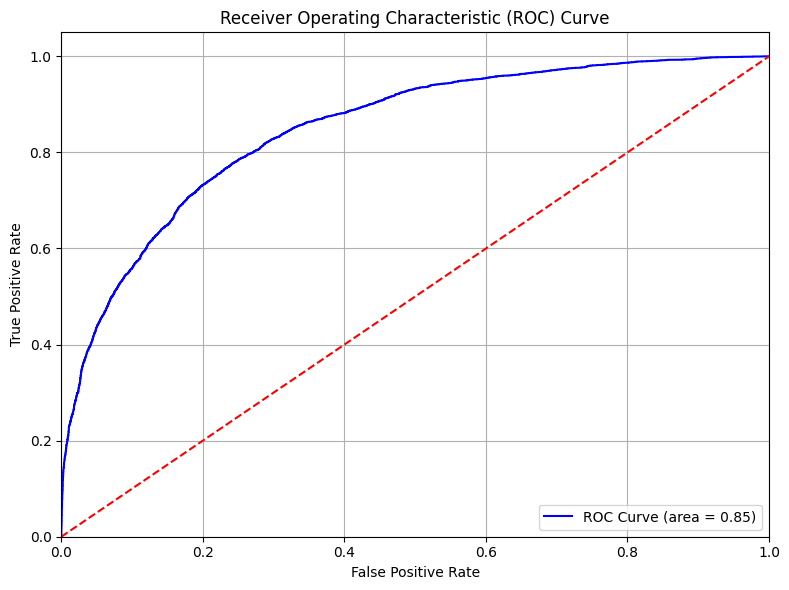

In [108]:
roc_auc = roc_auc_score(y_test, catClassifier.predict_proba(X_test)[:, 1])

print(f'ROC AUC score: {roc_auc}')

fpr, tpr, _ = roc_curve(y_test, catClassifier.predict_proba(X_test)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

# Make submission

## Inference

In [109]:
test_data = pd.read_parquet('./data/test.parquet')

In [110]:
test_data.head(1)

id                                              dates  \
0  6125  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   

                                              values  
0  [1.85, -0.04, 0.19, -0.45, -0.75, -0.95, -2.91...

In [113]:
def pipeline_extract_features(data):
    data['features'] = data['values'].apply(statistical_extract_features)
    data = pd.merge(data,
                pd.DataFrame(data['features'].tolist(),
                             columns=['mean', 'std', 'min','max','median', 'q25', 'q75', 'frequency', 'amplitude']).assign(id=data['id'].values),
                on='id', how='inner')
    data['trend'] = data.apply(lambda row: compute_slope(row['dates'], row['values']), axis=1)
    data['dv_mean'] = data['values'].apply(lambda x: np.mean(np.diff(x)))
    data['autocorr'] = data['values'].apply(lambda x: acf(x, nlags=1)[1])
    data['fft_freq'] = data['values'].apply(lambda x: np.fft.fftfreq(len(x)).mean())
    return data.drop(['features', 'values', 'dates'], axis=1)

In [ ]:
pipeline = Pipeline(steps=[
    ('feature_extraction', FunctionTransformer(pipeline_extract_features, validate=False)),
    ('scaler', StandardScaler()),
    ('classifier', catClassifier)
])

predictions = pipeline.predict(test_data)

In [ ]:
submission = pd.DataFrame({'id': test_data['id'], 'predicted': predictions})
submission.to_csv('submission.csv', index=False)